Proyecto Final Grupo 15

# Funciones auxiliares

Reutilizamos código dado en prácticas anteriores para el manejo de imágenes.

In [ ]:
'''
This function receives a string with the filename of the image to read,
and a flag indicating if we want to read it in color/RGB (flagColor=1) or gray level (flagColor=0)

Example of use:
im1=readIm(get_image('apple.jpg'),0)

'''
def readIm(filename, flagColor=1):
  # cv2 reads BGR format
  im=cv2.imread(filename)
  # change to  RGB and return the image
  if(flagColor):
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  # change from BGR to grayscale instead if flag is 0
  return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

In [ ]:
'''
This function receives an array of arbitrary real numbers (that could include even negative values),
and returns an 'image' in the range [0,1].
flag_GLOBAL allows the user to normalize the whole image (including all channels) or to normalize
each channel/band independently.
'''
def rangeDisplay01(im, flag_GLOBAL= True):
  im = im.astype(float)
  if flag_GLOBAL:
    im = (im - im.min())/(im.max() - im.min())
  else:
    # bands normalization
    for band in range(im.shape[2]):
      im[:, :, band] = (im[:, :, band] - im[:, :, band].min())/(im[:, :, band].max() - im[:, :, band].min())
      # Note: remember that, for plt.imshow with RGB data, the valid range is [0..1] for floats and [0..255] for integers.
  return im

In [ ]:
'''
This function displays a single image, including a title, using a magnification factor.

Example of use:
im1=readIm(get_image('apple.jpg'),0)
displayIm(im1,'Manzana',0.5)

'''
def displayIm(im, title='Result',factor= 2):
  # First normalize range
  max=np.max(im)
  min=np.min(im)
  if min<0 or max>255:
    im=rangeDisplay01(im,flag_GLOBAL=True)
  if len(im.shape) == 3:
    # im es tribanda
    plt.imshow(im, cmap='jet')
  else:
    # im es monobanda
    plt.imshow(im, cmap='gray')
  figure_size = plt.gcf().get_size_inches()
  plt.gcf().set_size_inches(factor * figure_size)
  plt.title(title)
  plt.xticks([]), plt.yticks([]) # eliminamos numeración
  plt.show()

In [ ]:
'''
This function displays multiple images (including a title and using a magnification factor)
of equal size. The input to the function is a list of images.

Example of use:
im1=readIm(get_image('apple.jpg'),1)
images = [im1,im1,im1]

displayMI_ES(images, title='Manzanas',factor=1)

'''
def displayMI_ES(vim, title='Result',factor=2):
  # We set the maximun number of images to concatenate by columns
  maxcolumns=3
  # number of images to display
  numberim=len(vim)
  # The simplest case, one row: the maximum number of columns is larger than the images to stack
  # This is, by default, we put together the images column-wise
  if len(vim) < maxcolumns:
    out=vim[0]
    for item in range(1,len(vim)):
      #displayIm(out,str(item),1)
      out=np.hstack((out,vim[item]))

  # Else, if maxcolumns is smaller or equal than the number of images to stack
  else:
    # We check if all rows and columns are going to be 'busy', or if otherwise we need an extra-row
    if np.mod(len(vim),maxcolumns)== 0:
      maxrows=numberim//maxcolumns
    else:
      maxrows=numberim//maxcolumns+1

    # we build up the first block-row
    out=vim[0]
    for item in range(1,maxcolumns):
      out=np.hstack((out,vim[item]))
    # We build up the rest of block-rows
    for block in range(1,maxrows):
      #print(block)
      row=vim[block*maxcolumns]
      for item in range(1,maxcolumns):
        # We still have images to stack
        if block*maxcolumns+item < numberim:
          row=np.hstack((row,vim[block*maxcolumns+item]))
        # We do not have more images, and we have to fill with black
        else:
          row=np.hstack((row,np.zeros(vim[0].shape,dtype=vim[0].dtype)))
          #print(row.dtype)
          # if we don't include ',dtype=vim[0].dtype', np.zeros will include float
          # numbers in the matrix. This will make that the whole matrix will be
          # considered as floats, and values larger than 1 will be clipped to 1,
          # displaying an almost totally white image
      # add the new block-row
      out=np.vstack((out,row))
  return displayIm(out,title,factor)

# Conexión con drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys,os
%cd '/content/drive/My Drive'
get_image = lambda route: os.path.join('/content/drive/MyDrive/VC_FINAL/Files', route)

Mounted at /content/drive
/content/drive/My Drive


# DATA

No aconsejamos ejecutar el colab por el tiempo de ejecución, pero por si se quisiera hacer, hemos implementado algunas condiciones para que no se vuelvan a realizar todos los cambios en el dataset que ya se han realizado previamente, con variables como "primera_ejecucion = False"

In [ ]:
!pip install opencv-python scikit-learn
!pip install Augmentor

import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from PIL import Image
import Augmentor
import os
from google.colab.patches import cv2_imshow
from sklearn.model_selection import GridSearchCV

Partimos de un dataset que contiene las siguientes clases de mosquitos invasoras:

- Culex: 1016 imágenes
- Albopictus: 1029 imágenes
- Aegypti: 75 imágenes
- Japonicus: 167 imágenes
- Koreicus: 39 imágenes
- Japonicus_koreicus (no se está seguro): 5 imágenes
- No se sabe: 462 imágenes

A este dataset vamos a realizarle algunas modificaciones para optimizar su clasificación:

- No tendremos en cuenta la clase de "No se sabe" puesto que no es ninguna etiqueta de mosquito como tal, solo confundiría a nuestro modelo, pues puede tener muchas clases distintas de mosquitos.
- El mosquito Aedes_Japonicus y Aedes_koreicus son mosquitos muy parecidos provenientes de Asia, vectores de las mismas enfermedades. Además, el aspecto físico es tan parecido que muchas veces crea confusión entre profesionales, por lo que al tener pocas imágenes de estas en comparación a otras clases, hemos decidido que será mejor unir ambas clases. Como eran pocas imágenes, unimos ambas clases de manera manual.
- DataAugmentation para suplir el desbalanceo de clases.
- Resize de las imágenes para mayor eficiencia del modelo.

Comprobación del tamaño de cada carpeta en donde se encuentra nuestro dataset:

In [ ]:
# Ruta de la carpeta principal
ruta_principal = '/content/drive/MyDrive/VC_FINAL/Files/'

# Inicializar contador de archivos
total_archivos = 0

# Recorrer todas las subcarpetas
for subcarpeta in os.listdir(ruta_principal):
    total_archivos = 0
    # Construir la ruta completa de la subcarpeta
    ruta_subcarpeta = os.path.join(ruta_principal, subcarpeta)

    # Verificar si es una carpeta
    if os.path.isdir(ruta_subcarpeta):
        # Obtener la lista de archivos en la subcarpeta
        archivos_subcarpeta = os.listdir(ruta_subcarpeta)

        # Contar la cantidad de archivos en la subcarpeta
        total_archivos += len(archivos_subcarpeta)
        print(f'{subcarpeta} : {total_archivos} archivos.')



Japonicus_koreicus : 5 archivos.
Aedes_japonicus : 167 archivos.
Aedes_koreicus : 39 archivos.
Aedes_albopictus : 1029 archivos.
Aedes_aegypti : 75 archivos.
Not_sure : 462 archivos.
Culex : 1016 archivos.
Culex_segmentadas : 768 archivos.
Aedes_albopictus_segmentadas : 730 archivos.
Aedes_japonicus_segmentadas : 98 archivos.
Aedes_koreicus_segmentadas : 25 archivos.
Aedes_albopictus_resized : 975 archivos.
Aedes_japonicus_resized : 145 archivos.
Culex_resized : 968 archivos.
Aedes_aegypti_resized : 275 archivos.
Japonicus_koreicus_segmentadas : 3 archivos.
Aedes_aegypti_segmentadas : 52 archivos.
Japonicus+koreicus : 210 archivos.
Japonicus+koreicus_resized : 587 archivos.
Japonicus+koreicus_segmentadas : 174 archivos.
Aedes_aegypti_segmentadas_resized : 202 archivos.
Japonicus+koreicus_segmentadas_resized : 506 archivos.
Aedes_albopictus_segmentadas_resized : 697 archivos.
Culex_segmentadas_resized : 730 archivos.
imagenes_ejemplos : 2 archivos.


Realizamos un resize a las clases originales y las guardamos en las carpetas:

" claseMosquito_resized "

Para ello, recorremos toda las subcarpetas originales del dataset leyendo cada imagen, le ajustamos el tamaño a 500x500 como máximo y la insertamos en la nueva carpeta claseMosquito_resized.

Además, se tiene en cuenta imágenes con valor nulo o tamaño 0 y no se añaden en estas nuevas carpetas.

In [ ]:
# Cargar imágenes y etiquetas de entrenamiento
redimensionar = True
primera_ejecucion = False

if primera_ejecucion:
    # Rutas de las carpetas que contienen las imágenes de cada especie
    folder_paths = ["/content/drive/MyDrive/VC_FINAL/Files/Culex", "/content/drive/MyDrive/VC_FINAL/Files/Aedes_albopictus",
                    "/content/drive/MyDrive/VC_FINAL/Files/Aedes_aegypti", "/content/drive/MyDrive/VC_FINAL/Files/Japonicus+koreicus"]

    output_folders = ["/content/drive/MyDrive/VC_FINAL/Files/Culex_resized", "/content/drive/MyDrive/VC_FINAL/Files/Aedes_albopictus_resized",
                    "/content/drive/MyDrive/VC_FINAL/Files/Aedes_aegypti_resized", "/content/drive/MyDrive/VC_FINAL/Files/Japonicus+koreicus_resized"]


    # Recorrer cada carpeta y obtener las rutas de las imágenes
    i=0
    tam = 500
    labels = []
    for label, (folder_path, output_folder) in enumerate(zip(folder_paths, output_folders)):
        # La variable 'label' se incrementa automáticamente para cada especie
        for filename in os.listdir(folder_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                #print("Accediendo a nueva imagen")
                # Construir la ruta completa de la imagen
                image_path = os.path.join(folder_path, filename)
                output_path = os.path.join(output_folder, filename)

                try:
                    # Intentar abrir la imagen con PIL
                    if redimensionar:
                      img = Image.open(image_path)
                    else:
                      img = Image.open(output_path)

                    # Verificar si la imagen no está vacía (sin píxeles)
                    if img.size != (0, 0):
                        if(redimensionar):
                          # Obtener el tamaño mínimo
                          # 600 x 200 -> 500 x 200
                          w,h = img.size
                          min_w = min(w, tam)
                          min_h = min(h, tam)
                          # Redimensionar la imagen
                          img_resized = img.resize((min_w,min_h))
                          # Guardar la imagen redimensionada en otra carpeta
                          img_resized.save(output_path)

                          labels.append(label)
                          #i=i+1
                          #print("Imagen insertada!", i)
                    else:
                        print(f"Imagen vacía: {image_path}")
                except Exception as e:
                    print(f"Error al procesar la imagen {image_path}: {str(e)}")

print("Insertadas todas las imágenes con resized en las nuevas carpetas")
print("culex:",labels.count(0))
print("albopictus:",labels.count(1))
print("aegypti:",labels.count(2))
print("japonicus + koreicus:",labels.count(3))

Error al procesar la imagen /content/drive/MyDrive/VC_FINAL/Files/Aedes_albopictus/052c8919-b815-4a6b-a731-0011863160f8.jpg: cannot identify image file '/content/drive/MyDrive/VC_FINAL/Files/Aedes_albopictus/052c8919-b815-4a6b-a731-0011863160f8.jpg'
Error al procesar la imagen /content/drive/MyDrive/VC_FINAL/Files/Aedes_albopictus/10d42fbf-6e1b-4645-a6ac-afa7bad98b3d.jpg: cannot identify image file '/content/drive/MyDrive/VC_FINAL/Files/Aedes_albopictus/10d42fbf-6e1b-4645-a6ac-afa7bad98b3d.jpg'
Error al procesar la imagen /content/drive/MyDrive/VC_FINAL/Files/Aedes_albopictus/08a38e6e-2270-4369-b3bd-024659c2f1a0.jpg: cannot identify image file '/content/drive/MyDrive/VC_FINAL/Files/Aedes_albopictus/08a38e6e-2270-4369-b3bd-024659c2f1a0.jpg'
Error al procesar la imagen /content/drive/MyDrive/VC_FINAL/Files/Aedes_albopictus/049e8a01-04ff-40ee-ad46-5033d2f68ab5.jpg: cannot identify image file '/content/drive/MyDrive/VC_FINAL/Files/Aedes_albopictus/049e8a01-04ff-40ee-ad46-5033d2f68ab5.jpg'


Para aplicar Aumento de Datos en solo las clases con menos imágenes, iteramos en dichas clases (aegypti y japonicus+koreicus) y aumentaremos dichas imágenes con la librería Augmentor.  Las transformaciones que aplicamos serán:

- rotaciones de 25º (la librería no permite más) con un 70% de probabilidad
- voltear la imágen verticalmente con un 50% de probabilidad
- voltear la imágen horizontalmente con un 50% de probabilidad

A las clases le aumentaremos las imágenes de la siguiente manera:
- Aegipty: 75 → 275
- Japonicus+koreicus: 211 → 587

No podemos aumentar los datos, por ejemplo, de 75 → 1000 pues serían datos redundantes con mucha repetitividad. Más adelante explicaremos otra decisión para suplir el desbalanceo de clases.

In [ ]:
def data_augmentation(diccionario_clases, diccionario_clases_salida):
  # Definir la ruta de la carpeta que contiene las clases desbalanceadas
  ruta_dataset = '/content/drive/MyDrive/VC_FINAL/Files/'

  # Definir las clases que quieres aumentar
  clases_aumentar = ['aegypti', 'japonicus_koreicus']

  # Iterar sobre las clases que deseas aumentar
  for clase in clases_aumentar:
      # Definir la carpeta de entrada para la clase actual
      carpeta_entrada = os.path.join(ruta_dataset, diccionario_clases[clase])
      carpeta_salida = os.path.join(ruta_dataset, diccionario_clases_salida[clase])

      # Crear un objeto Augmentor para la carpeta de entrada
      pipeline = Augmentor.Pipeline(carpeta_entrada, carpeta_salida)

      # Aplicar las operaciones de aumento de datos que desees
      # Por ejemplo, puedes usar rotate, flip_horizontal, flip_vertical, etc.
      pipeline.rotate(probability=0.7, max_left_rotation=25, max_right_rotation=25)
      pipeline.flip_left_right(probability=0.5)
      pipeline.flip_top_bottom(probability=0.5)

      # Especificar cuántas imágenes nuevas deseas generar para cada clase
      if clase == 'aegypti':
        print("Aumentando data de aegypti")
        num_aegypti_2 = sum(1 for label in labels if label == "2")
        print(f"Sumando 200 imágenes a las {num_aegypti_2} existentes")
        num_nuevas_imagenes = 200

      elif clase == 'japonicus_koreicus':
        print("Aumentando data de japonicus_koreicus")
        num_jap_kor_3 = sum(1 for label in labels if label == "3")
        print(f"Sumando 400 imágenes a las { num_jap_kor_3} existentes")
        num_nuevas_imagenes = 400
      else:
        print("Error al aumentar la data")

      # Ejecutar el aumento de datos
      pipeline.sample(num_nuevas_imagenes)

  print("Aumento de datos completado.")


Como estamos usando carpetas compartidas, debemos tener cuidado de no ejecutar este tipo de celdas más de una vez, puesto que aplicariamos data_augmentation a una carpeta en donde ya se ha realizado data augmentation.

In [ ]:
data_augmention = False

if data_augmention:
  # Crear un diccionario que asocie las clases con sus respectivas carpetas
  diccionario_clases = {'aegypti': 'Aedes_aegypti_resized', 'japonicus_koreicus': 'Japonicus+koreicus_resized'}
  diccionario_clases_salida = {'aegypti': 'Aedes_aegypti_resized', 'japonicus_koreicus': 'Japonicus+koreicus_resized'}

  # Llamar a la función que aplica data augmentation
  data_augmentation(diccionario_clases,diccionario_clases_salida)

Initialised with 75 image(s) found.
Output directory set to /content/drive/MyDrive/VC_FINAL/Files/Aedes_aegypti_resized.Aumentando data de aegypti
Sumando 200 imágenes a las 0 existentes


Processing <PIL.Image.Image image mode=RGB size=500x500 at 0x7976F0927E20>: 100%|██████████| 200/200 [00:05<00:00, 36.80 Samples/s]


Initialised with 187 image(s) found.
Output directory set to /content/drive/MyDrive/VC_FINAL/Files/Japonicus+koreicus_resized.Aumentando data de japonicus_koreicus
Sumando 400 imágenes a las 0 existentes


Processing <PIL.Image.Image image mode=RGB size=500x500 at 0x7976F09A6110>: 100%|██████████| 400/400 [00:14<00:00, 28.43 Samples/s]

Aumento de datos completado.


Teniendo todas las imágenes que necesitamos en las carpetas, las guardaremos en

"image_paths"

y sus etiquetas correspondientes en

"labels"

In [ ]:
# Declarar las rutas de cada clase
folders = ["/content/drive/MyDrive/VC_FINAL/Files/Culex_resized/", "/content/drive/MyDrive/VC_FINAL/Files/Aedes_albopictus_resized/",
                "/content/drive/MyDrive/VC_FINAL/Files/Aedes_aegypti_resized/", "/content/drive/MyDrive/VC_FINAL/Files/Japonicus+koreicus_resized/"]

# Lista para almacenar las rutas de todas las imágenes y las etiquetas correspondientes
image_paths = []
labels = []

for label in [0,1,2,3]:
    folder = folders[label]
    print("Ubicación: ", folder)

    # Obtener las imágenes
    images_tmp = [folder + f for f in sorted(os.listdir(folder))]
    image_paths = image_paths + images_tmp
    print("Numero de imágenes totales: ", len(image_paths))
    label_tmp = [label] * len(images_tmp)
    print("Numero de imágenes en esta clase: ", len(label_tmp))
    labels = labels + label_tmp
    print("Numero de etiquetas totales: ", len(labels))

Ubicación:  /content/drive/MyDrive/VC_FINAL/Files/Culex_resized/
Numero de imágenes totales:  968
Numero de imágenes en esta clase:  968
Numero de etiquetas totales:  968
Ubicación:  /content/drive/MyDrive/VC_FINAL/Files/Aedes_albopictus_resized/
Numero de imágenes totales:  1943
Numero de imágenes en esta clase:  975
Numero de etiquetas totales:  1943
Ubicación:  /content/drive/MyDrive/VC_FINAL/Files/Aedes_aegypti_resized/
Numero de imágenes totales:  2218
Numero de imágenes en esta clase:  275
Numero de etiquetas totales:  2218
Ubicación:  /content/drive/MyDrive/VC_FINAL/Files/Japonicus+koreicus_resized/
Numero de imágenes totales:  2805
Numero de imágenes en esta clase:  587
Numero de etiquetas totales:  2805


Dividimos el dataset en training (90%) y test (10%). Debemos tener en cuenta que si lo dividimos aleatoriamente, al tener desbalanceo de clases, en test obtendremos menos datos de las clases minoritarias, por lo que si nuestro modelo aprende erroneamente a clasificar solo las clases mayoritarias, no podríamos darnos cuenta con las pruebas de test.

Por lo cual, usamos un parámetro que intenta que todas las clases tengan la misma representación:

stratify=labels

In [ ]:
# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.1, random_state=42, stratify=labels)

print("Tamaño training: ", len(X_train))

Tamaño training:  2524


# BAG OF WORDS

En este collab, nos basaremos en el algoritmo Bag Of Words para obtener la representación vectorial de una imagen con la cual podremos clasificarla con Support Vector Classifier.

Para cada imagen en BoW, extraemos sus características (keypoints + descriptors) mediante SIFT (en nuestro caso, 200). Con el conjunto de descriptores de todas las imágenes con las que se entrena, agrupa a todos ellos en un conjunto finito de "palabras visuales" mediante técnicas de agrupación. En nuestro caso, los descriptores se asignan a clusteres mediante el algoritmo K_Means.

Una vez tenemos el diccionario de palabras visuales, al insertar una nueva imagen podemos contar las ocurrencias de las palabras visuales del diccionario en esta, obteniendo asi un historigrama de la frecuencia de cada palabra a lo largo de la imagen.

Este histograma en forma de vector es el input del modelo de clasificación, en nuestro caso SVM.

Consideramos que la clasificación de mosquitos mediante BoW es una buena idea puesto que la clasificación de estos se basan en detectar patrones característicos, por lo que no es tan importante su localización respecto al resto de cosas en la imágen. Además, SIFT es un modelo robusto frente a transformaciones de escala, rotación e iluminación, por lo que ayuda al problema de obtener fotos desde cualquier perspectiva realizadas en sitios con iluminaciones diferentes.

Para extraer los descriptores mediante SIFT, usamos la librería openCV

In [ ]:
# Función para extraer descriptores locales (por ejemplo, usando ORB)
def extract_local_descriptors(image_path, representation=False):

    # Leer la imagen y la procesamos para sift
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is not None:
        image8bit = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

        # Crear el objeto SIFT
        sift = cv2.SIFT_create(nfeatures=200)

        # Encontrar keypoints y descriptores usando SIFT
        keypoints, descriptors = sift.detectAndCompute(image, None)

        # Manejar valor None en las imágenes
        if descriptors is None:
            print('descriptor tamaño NONE')
            return None

        if representation:
            return keypoints, descriptors

        #print("descriptor tamaño: ",len(descriptors))
        return descriptors

    return None

Para implementar el modelo, recorremos cada imágen obteniendo sus descriptores, los cuales insertaremos en una lista de descriptores. Esta lista es la que pasaremos al algorimto K-Means para que los agrupe en clusteres (en nuestro caso, 50)

In [ ]:
# Función para crear el modelo Bag of Visual Words
def create_bow_model(image_paths, num_clusters,labels):

  # Obtenemos los descriptores
  #num_label=0
  indicador = 0
  descriptors_list = []
  for path in image_paths:

      descriptors = extract_local_descriptors(path)

      if(descriptors is None):
        #labels.pop(num_label)
        print("None")
      else:
        descriptors_list.extend(descriptors)
        #num_label=num_label+1
      indicador = indicador+1
      #print(indicador)

  descriptors_list = np.array(descriptors_list)
  print("Creada lista de descriptores")

  # Los agrupamos en clusters
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(descriptors_list)
  print("Ajustados los clusteres mediante K-Means")

  return kmeans

Una vez obtenemos los clusteres (palabras visuales), representaremos cada imágen como un vector de estas.

Obtenemos los descriptores de la imagen y a qué clusteres corresponden, construyendo un historigrama de la frecuencia de estos.

In [ ]:
# Función para representar una imagen como un vector de características BoW
def image_to_bow_vector(image_path, kmeans):
    descriptors = extract_local_descriptors(image_path)
    bow_vector = np.zeros(len(kmeans.cluster_centers_))

    # Correspondencia descriptores - palabra visual
    if descriptors is not None:
        labels = kmeans.predict(descriptors)
        # Crear historigrama en forma de vector
        for label in labels:
            bow_vector[label] += 1

    return bow_vector

In [ ]:
# Crear modelo BoW
num_clusters = 50  # Número de clusters para KMeans
bow_model = create_bow_model(X_train, num_clusters,y_train)

Creada lista de descriptores


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Ajustados los clusteres mediante K-Means


In [ ]:
# Representar imágenes como vectores BoW
X_train_bow = [image_to_bow_vector(path, bow_model) for path in X_train]
X_test_bow = [image_to_bow_vector(path, bow_model) for path in X_test]

En este punto ya tenemos en X_train_bow las imágenes de training en forma de histogramas de palabras visuales, e igual para X_test_bow

# SVC

Support Vector Classifier es un algoritmo de clasificador de datos que puede usarse como regresión logística. Este representa el conjunto de datos en un espacio de características y busca el hiperplano que mejor separa las clases. Para encontrarlo, se toman en cuenta los puntos más cercanos a este (vectores de soporte) y se define el margen entre estos y el hiperplano. El objetivo de SVC es maximizar dicho margen (Maximal Margin Classifier)

En la práctica, usamos la librería sklearn.svm y debemos tener en cuenta los hiperparámetros que podemos modificar:

**C (1.0):** regularización que da equilibrio entre un margen más amplio y clasificar correctamente.

kernel (rbf): Puede tomar los valores {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}

**gamma (scale)**: influencia de un ejemplo sobre el resto, a grandes rasgos, controla la flexibilidad.

tol (1e3): la tolerancia en el criterio de parada

max_iter (-1): numero máximo de iteraciones

**class_weight (None):** Controla los pesos asignados a cada clase durante el entrenamiento. Usando el valor "balanced" se asignan pesos inversamente proporcionales al número de muestras en cada clase se para mejorar el **desbalanceo de clases**.

In [ ]:
accuracys = []

## SVC Balanceo de clases

In [ ]:
# Entrenar un clasificador (por ejemplo, un clasificador de máquinas de soporte vectorial - SVM)
classifier = SVC(class_weight='balanced')
classifier.fit(X_train_bow, y_train)

SVC(class_weight='balanced')

In [ ]:
# Realizar predicciones en el conjunto de prueba
predictions = classifier.predict(X_test_bow)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_test, predictions)
accuracys.append(accuracy)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

Precisión del modelo: 53.74%


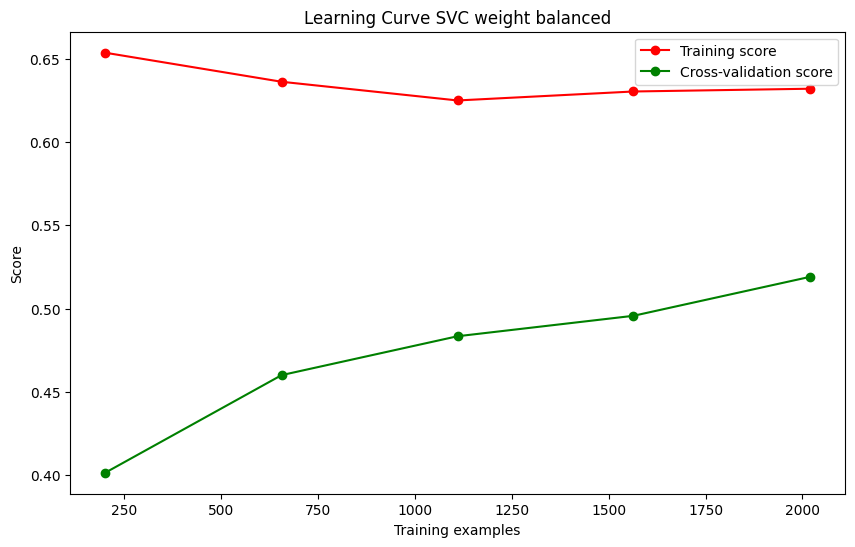

In [ ]:
# Obtener las curvas de aprendizaje
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    classifier, X_train_bow, y_train, cv=5, scoring='accuracy', n_jobs=-1)

# Calcular las medias de las puntuaciones
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar las curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve SVC weight balanced")
plt.show()

Obtenemos un 50% de accuracy. Al comienzo es capaz de clasificar en training hasta un 75% de accuracy pero eso significa sobreajustarse a los datos, por lo que en validación obtiene un accuracy muy bajo. Conforme obtenemos más datos, el accuracy de training va disminuyendo (clasificar más ejemplos es más dificil) pero el accuracy de validation va aumentando, ya que está aprendiendo a clasificar.

Como veremos más adelante, conseguiremos este patrón en todos los siguientes intentos de optimización. El objetivo de estos será que la curva de aprendizaje de Validation sea más pronunciada, es decir, aprenda a clasificar más rápido y obtenga una mayor puntuación para el mismo número de ejemplos.

## SVC + Balanceo * Decremento de regularización C=0.5

In [ ]:
# Entrenar un clasificador (por ejemplo, un clasificador de máquinas de soporte vectorial - SVM)
classifier = SVC(class_weight='balanced', C=0.5)
classifier.fit(X_train_bow, y_train)

SVC(C=0.5, class_weight='balanced')

In [ ]:
# Realizar predicciones en el conjunto de prueba
predictions = classifier.predict(X_test_bow)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_test, predictions)
accuracys.append(accuracy)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

Precisión del modelo: 50.89%


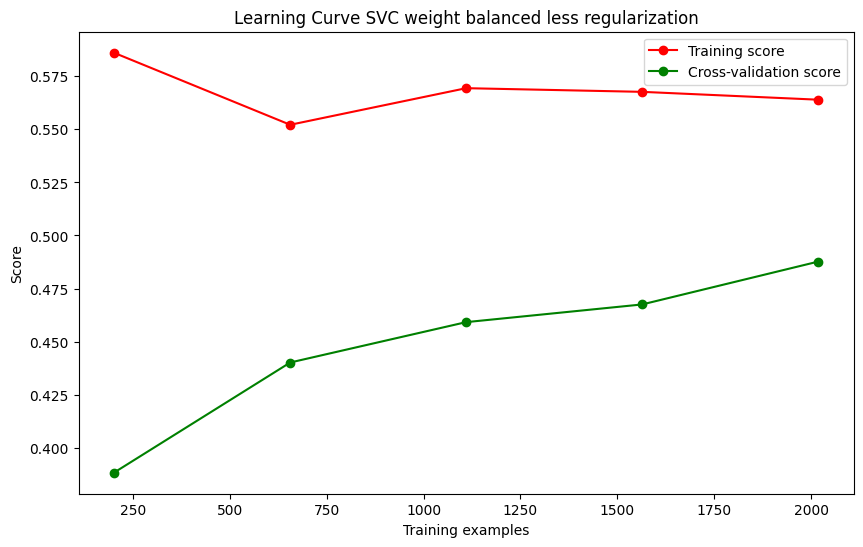

In [ ]:
# Obtener las curvas de aprendizaje
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    classifier, X_train_bow, y_train, cv=5, scoring='accuracy', n_jobs=-1)

# Calcular las medias de las puntuaciones
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar las curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve SVC weight balanced less regularization")
plt.show()

Con menos regularización podríamos aumentar la expresividad del modelo corriendo el riesgo de sobreajustar. Como vemos, el accuracy de training es capaz de mejorar a la vez que en validation, pero este comienza más bajo aún y no consigue mejorar el resultado de validación respecto al anterior.

## SVC + balanceo + kernel = poly

Podríamos probar el rendimiento de otro kernel popular, un kernel polinomial.

In [ ]:
# Entrenar un clasificador (por ejemplo, un clasificador de máquinas de soporte vectorial - SVM)
classifier = SVC(class_weight='balanced', kernel='poly')
classifier.fit(X_train_bow, y_train)

SVC(class_weight='balanced', kernel='poly')

In [ ]:
# Realizar predicciones en el conjunto de prueba
predictions = classifier.predict(X_test_bow)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_test, predictions)
accuracys.append(accuracy)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

Precisión del modelo: 53.74%


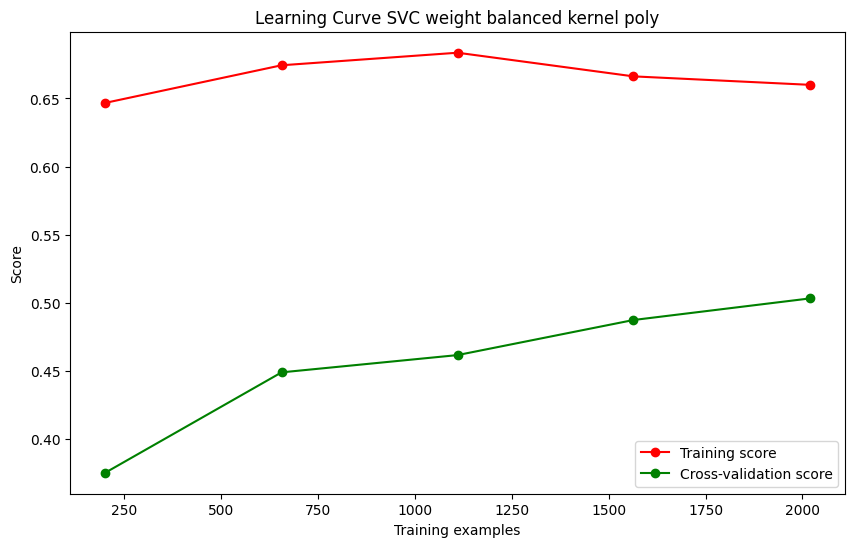

In [ ]:
# Obtener las curvas de aprendizaje
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    classifier, X_train_bow, y_train, cv=5, scoring='accuracy', n_jobs=-1)

# Calcular las medias de las puntuaciones
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar las curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve SVC weight balanced kernel poly")
plt.show()



Con otro kernel, obtenemos una puntuación de validación similar, no parece conseguir una diferencia respecto al kernel por defecto rbf

## SVC kernel poly degree > 3

Existe un parámetro que podemos modificar en el polinomio, y es el grado del mismo. Si aumentamos el grado del polinomio, obtendremos mayor expresividad, a si que probaremos con un polinomio de grado 5.

In [ ]:
# Entrenar un clasificador (por ejemplo, un clasificador de máquinas de soporte vectorial - SVM)
classifier = SVC(class_weight='balanced', kernel='poly', degree = 5)
classifier.fit(X_train_bow, y_train)

SVC(class_weight='balanced', degree=5, kernel='poly')

In [ ]:
# Realizar predicciones en el conjunto de prueba
predictions = classifier.predict(X_test_bow)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_test, predictions)
accuracys.append(accuracy)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

Precisión del modelo: 51.60%


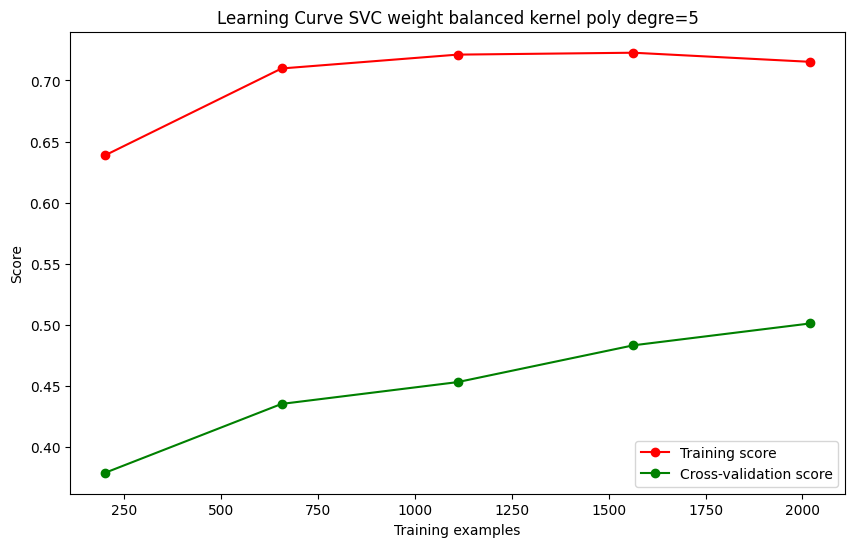

In [ ]:
# Obtener las curvas de aprendizaje
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    classifier, X_train_bow, y_train, cv=5, scoring='accuracy', n_jobs=-1)

# Calcular las medias de las puntuaciones
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar las curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve SVC weight balanced kernel poly degre=5")
plt.show()

El accuracy de training aumenta muy considerablemente, pero no implica un mayor crecimiento en validación, por lo que no nos sirve.

## SVC kernel poly degree < 3

Disminuir el grado del kernel disminuirá su expresividad. Esto puede ayudar a la generalización del modelo. Darle más expresividad no ayudó, por lo que me gustaría averiguar que pasaría si hacemos lo contrario.

In [ ]:
# Entrenar un clasificador (por ejemplo, un clasificador de máquinas de soporte vectorial - SVM)
classifier = SVC(class_weight='balanced', kernel='poly', degree = 2)
classifier.fit(X_train_bow, y_train)

SVC(class_weight='balanced', degree=2, kernel='poly')

In [ ]:
# Realizar predicciones en el conjunto de prueba
predictions = classifier.predict(X_test_bow)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_test, predictions)
accuracys.append(accuracy)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

Precisión del modelo: 53.02%


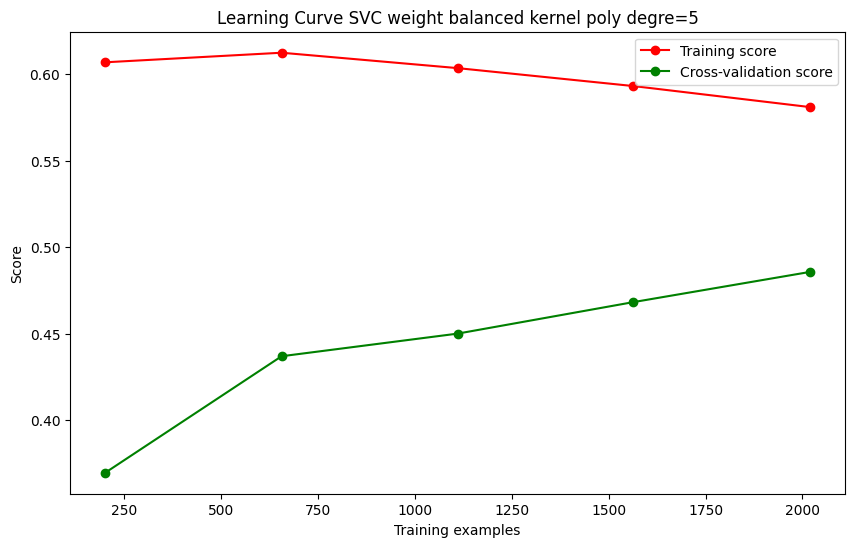

In [ ]:
# Obtener las curvas de aprendizaje
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    classifier, X_train_bow, y_train, cv=5, scoring='accuracy', n_jobs=-1)

# Calcular las medias de las puntuaciones
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar las curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve SVC weight balanced kernel poly degre=5")
plt.show()

Obtiene un mejor resultado que al aumentar el grado del polinomio, pero nada fuera de lo normal. Parece ser que los parámetros por defecto de SVC son los que mejor resultado nos da. No es algo descabellado, pues dichos parámetros no están seleccionados al azar, si no que mediante mucho tiempo de experimentación por parte de usuarios que han utilizado la librería han ayudado a seleccionar por defecto una buena combinación genérica de estos, aunque pueden perfectamente existir casos en donde otra combinación funcione mejor.

#CLASIFICACIÓN CON DETECCIÓN PREVIA

Uno de los principales problemas que encontramos en nuestro dataset es que las imágenes no son profesionales. Estan tomadas por muchas personas distintas en situaciones y lugares distintos, por lo cual no podemos esperar una calidad de imágenes como si estuvieran tomadas en laboratorio. Algunas fotos tienen a los mosquitos muy cerca, otros muy lejos, otras con el mosquito en la mano y otras sobre superficies con patrones (el fondo no es neutro). Por lo cual, muchos descriptores de BoW serán destinados a puntos de interés que no tienen que ver con los mosquitos, lo que aumenta muchísimo el ruido y no permite una buena clasificación.

Una idea para solucionar eso, es detectar al mosquito en la imagen y quedarnos con la parte en donde se encuentra. La idea tras ello sería que los keypoints detectados por SIFT sean principalmente del mosquito, y no del ruido a su alrededor.

200 198


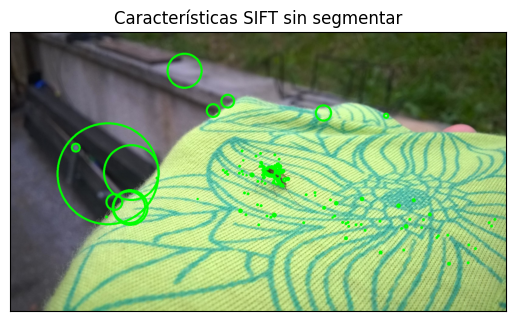

----


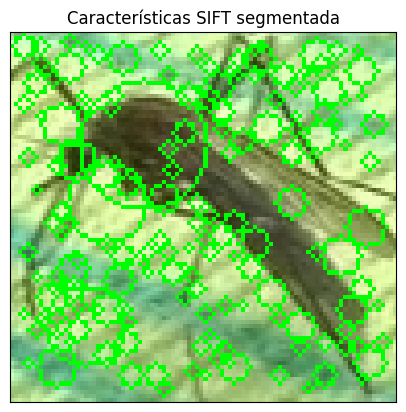

In [ ]:
example1_path = '/content/drive/MyDrive/VC_FINAL/Files/imagenes_ejemplos/im1.jpg'
example2_path = '/content/drive/MyDrive/VC_FINAL/Files/imagenes_ejemplos/im2.jpg'

img1=readIm(get_image(example1_path),1)
img2=readIm(get_image(example2_path),1)

# Obtener keypoints
kp1,ds = extract_local_descriptors(example1_path, representation = True)
kp2,ds = extract_local_descriptors(example2_path,representation = True)

def drawKeyPts(im,keyp,col,th):
    for curKey in keyp:
        x=int(curKey.pt[0])
        y=int(curKey.pt[1])
        size = int(curKey.size)
        cv2.circle(im,(x,y),size, col,thickness=th, lineType=8, shift=0)
    plt.imshow(im)
    return im


print(len(kp1),len(kp2))
im1WithCircles = drawKeyPts(img1.copy(),kp1,(0,255,0),5)
displayIm(im1WithCircles,"Características SIFT sin segmentar",1)
print("----")
im2WithCircles = drawKeyPts(img2.copy(),kp2,(0,255,0),1)
displayIm(im2WithCircles,"Características SIFT segmentada",1)

In [ ]:
# Cargar imágenes y etiquetas de entrenamiento
redimensionar = False

if primera_ejecucion:
    # Rutas de las carpetas que contienen las imágenes de cada especie
    folder_paths = ["/content/drive/MyDrive/VC_FINAL/Files/Culex_segmentadas", "/content/drive/MyDrive/VC_FINAL/Files/Aedes_albopictus_segmentadas",
                    "/content/drive/MyDrive/VC_FINAL/Files/Aedes_aegypti_segmentadas", "/content/drive/MyDrive/VC_FINAL/Files/Japonicus+koreicus_segmentadas"]

    output_folders = ["/content/drive/MyDrive/VC_FINAL/Files/Culex_segmentadas_resized", "/content/drive/MyDrive/VC_FINAL/Files/Aedes_albopictus_segmentadas_resized",
                    "/content/drive/MyDrive/VC_FINAL/Files/Aedes_aegypti_segmentadas_resized", "/content/drive/MyDrive/VC_FINAL/Files/Japonicus+koreicus_segmentadas_resized"]

    # Lista para almacenar las rutas de todas las imágenes y las etiquetas correspondientes
    image_paths = []
    labels = []
    i=0
    tam = 500

    # Recorrer cada carpeta y obtener las rutas de las imágenes
    for label, (folder_path, output_folder) in enumerate(zip(folder_paths, output_folders)):
        # La variable 'label' se incrementa automáticamente para cada especie
        for filename in os.listdir(folder_path):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                print("nueva imagen")
                # Construir la ruta completa de la imagen
                #if(folder_path == '/content/drive/MyDrive/VC_FINAL/Files/Japonicus+koreicus'):
                image_path = os.path.join(folder_path, filename)
                output_path = os.path.join(output_folder, filename)

                try:
                    # Intentar abrir la imagen con PIL
                    if redimensionar:
                      img = Image.open(image_path)
                    else:
                      img = Image.open(output_path)

                    # Verificar si la imagen no está vacía (sin píxeles)
                    if img == None:
                      print("None")
                    else:
                      if img.size != (0, 0):

                          if(redimensionar):
                            w,h = img.size
                            min_w = min(w, tam)
                            min_h = min(h, tam)
                            # Redimensionar la imagen a 500x500 píxeles
                            img_resized = img.resize((min_w,min_h))
                            # Guardar la imagen redimensionada en otra carpeta
                            img_resized.save(output_path)

                          # Agregar la ruta de la imagen y la etiqueta a las listas
                          image_paths.append(output_path)
                          labels.append(label)
                          i=i+1
                          print("insertada!", i)
                      else:
                          print(f"Imagen vacía: {image_path}")
                except Exception as e:
                    print(f"Error al procesar la imagen {image_path}: {str(e)}")

In [ ]:
# Ruta de la carpeta principal
ruta_principal = '/content/drive/MyDrive/VC_FINAL/Files/'

# Inicializar contador de archivos
total_archivos = 0

# Recorrer todas las subcarpetas
for subcarpeta in os.listdir(ruta_principal):
    total_archivos = 0
    # Construir la ruta completa de la subcarpeta
    ruta_subcarpeta = os.path.join(ruta_principal, subcarpeta)

    # Verificar si es una carpeta
    if os.path.isdir(ruta_subcarpeta):
        # Obtener la lista de archivos en la subcarpeta
        archivos_subcarpeta = os.listdir(ruta_subcarpeta)

        # Contar la cantidad de archivos en la subcarpeta
        total_archivos += len(archivos_subcarpeta)
        print(f'{subcarpeta} : {total_archivos} archivos.')

Japonicus_koreicus : 5 archivos.
Aedes_japonicus : 167 archivos.
Aedes_koreicus : 39 archivos.
Aedes_albopictus : 1029 archivos.
Aedes_aegypti : 75 archivos.
Not_sure : 462 archivos.
Culex : 1016 archivos.
Culex_segmentadas : 768 archivos.
Aedes_albopictus_segmentadas : 730 archivos.
Aedes_japonicus_segmentadas : 98 archivos.
Aedes_koreicus_segmentadas : 25 archivos.
Aedes_albopictus_resized : 975 archivos.
Aedes_japonicus_resized : 145 archivos.
Culex_resized : 968 archivos.
Aedes_aegypti_resized : 275 archivos.
Japonicus_koreicus_segmentadas : 3 archivos.
Aedes_aegypti_segmentadas : 52 archivos.
Japonicus+koreicus : 211 archivos.
Japonicus+koreicus_resized : 587 archivos.
Japonicus+koreicus_segmentadas : 174 archivos.
Aedes_aegypti_segmentadas_resized : 202 archivos.
Japonicus+koreicus_segmentadas_resized : 506 archivos.
Aedes_albopictus_segmentadas_resized : 697 archivos.
Culex_segmentadas_resized : 730 archivos.


In [ ]:
#EFICIENTE
folders = ["/content/drive/MyDrive/VC_FINAL/Files/Culex_segmentadas_resized/", "/content/drive/MyDrive/VC_FINAL/Files/Aedes_albopictus_segmentadas_resized/",
                "/content/drive/MyDrive/VC_FINAL/Files/Aedes_aegypti_segmentadas_resized/", "/content/drive/MyDrive/VC_FINAL/Files/Japonicus+koreicus_segmentadas_resized/"]

# Lista para almacenar las rutas de todas las imágenes y las etiquetas correspondientes
image_paths = []
labels = []

for label in [0,1,2,3]:
    folder = folders[label]
    print("Ubicación: ", folder)

    # Obtener las imágenes
    images_tmp = [folder + f for f in sorted(os.listdir(folder))]
    image_paths = image_paths + images_tmp
    print("Numero de imágenes totales: ", len(image_paths))
    label_tmp = [label] * len(images_tmp)
    print("Numero de imágenes en esta clase: ", len(label_tmp))
    labels = labels + label_tmp
    print("Numero de etiquetas totales: ", len(labels))

Ubicación:  /content/drive/MyDrive/VC_FINAL/Files/Culex_segmentadas_resized/
Numero de imágenes totales:  730
Numero de imágenes en esta clase:  730
Numero de etiquetas totales:  730
Ubicación:  /content/drive/MyDrive/VC_FINAL/Files/Aedes_albopictus_segmentadas_resized/
Numero de imágenes totales:  1427
Numero de imágenes en esta clase:  697
Numero de etiquetas totales:  1427
Ubicación:  /content/drive/MyDrive/VC_FINAL/Files/Aedes_aegypti_segmentadas_resized/
Numero de imágenes totales:  1629
Numero de imágenes en esta clase:  202
Numero de etiquetas totales:  1629
Ubicación:  /content/drive/MyDrive/VC_FINAL/Files/Japonicus+koreicus_segmentadas_resized/
Numero de imágenes totales:  2135
Numero de imágenes en esta clase:  506
Numero de etiquetas totales:  2135


Podemos observar que al obtener las imágenes de segmentación, se reduce el número. Esto pasa porque existen casos en donde la red de segmentación no encuentra ningún objeto identificable y no devuelve nada. En estos casos no obtenemos la imagen.

In [ ]:
# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.1, random_state=42,stratify=labels)

In [ ]:
# Crear modelo BoW
num_clusters = 50  # Número de clusters para KMeans
bow_model = create_bow_model(X_train, num_clusters,y_train)

descriptor tamaño NONE
None
descriptor tamaño NONE
None
descriptor tamaño NONE
None
descriptor tamaño NONE
None
descriptor tamaño NONE
None
descriptor tamaño NONE
None
descriptor tamaño NONE
None
descriptor tamaño NONE
None
Creada lista de descriptores


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Ajustados los clusteres mediante K-Means


In [ ]:
# Representar imágenes como vectores BoW
X_train_bow = [image_to_bow_vector(path, bow_model) for path in X_train]
X_test_bow = [image_to_bow_vector(path, bow_model) for path in X_test]

descriptor tamaño NONE
descriptor tamaño NONE
descriptor tamaño NONE
descriptor tamaño NONE
descriptor tamaño NONE
descriptor tamaño NONE
descriptor tamaño NONE
descriptor tamaño NONE
descriptor tamaño NONE


## SVC Data Augmentation

### Data Augmentation

In [ ]:
def data_augmentation2(diccionario_clases, diccionario_clases_salida):
  # Definir la ruta de la carpeta que contiene las clases desbalanceadas
  ruta_dataset = '/content/drive/MyDrive/VC_FINAL/Files/'

  # Definir las clases que quieres aumentar
  clases_aumentar = ['aegypti', 'japonicus_koreicus']

  # Iterar sobre las clases que deseas aumentar
  for clase in clases_aumentar:
      # Definir la carpeta de entrada para la clase actual
      carpeta_entrada = os.path.join(ruta_dataset, diccionario_clases[clase])
      carpeta_salida = os.path.join(ruta_dataset, diccionario_clases_salida[clase])

      # Crear un objeto Augmentor para la carpeta de entrada
      pipeline = Augmentor.Pipeline(carpeta_entrada, carpeta_salida)

      # Aplicar las operaciones de aumento de datos que desees
      # Por ejemplo, puedes usar rotate, flip_horizontal, flip_vertical, etc.
      pipeline.rotate(probability=0.7, max_left_rotation=25, max_right_rotation=25)
      pipeline.flip_left_right(probability=0.5)
      pipeline.flip_top_bottom(probability=0.5)

      # Especificar cuántas imágenes nuevas deseas generar
      if clase == 'aegypti':
        print("Aumentando data de aegypti")
        num_aegypti_2 = sum(1 for label in labels if label == "2")
        print(f"Sumando 200 imágenes a las {num_aegypti_2} existentes")
        num_nuevas_imagenes = 150

      elif clase == 'japonicus_koreicus':
        print("Aumentando data de japonicus_koreicus")
        num_jap_kor_3 = sum(1 for label in labels if label == "3")
        print(f"Sumando 400 imágenes a las { num_jap_kor_3} existentes")
        num_nuevas_imagenes = 350

      else:
        print("Error al aumentar la data")

      # Ejecutar el aumento de datos
      pipeline.sample(num_nuevas_imagenes)

  print("Aumento de datos completado.")

In [ ]:
segmented_augmentation = False

if segmented_augmentation:
  # Crear un diccionario que asocie las clases con sus respectivas carpetas
  diccionario_clases = {'aegypti': 'Aedes_aegypti_segmentadas_resized', 'japonicus_koreicus': 'Japonicus+koreicus_segmentadas_resized'}
  diccionario_clases_salida = {'aegypti': 'Aedes_aegypti_segmentadas_resized', 'japonicus_koreicus': 'Japonicus+koreicus_segmentadas_resized'}
  data_augmentation2(diccionario_clases,diccionario_clases_salida)

### Training

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_paths, labels, test_size=0.1, random_state=42, stratify=labels)

In [ ]:
# Crear modelo BoW
num_clusters = 50  # Número de clusters para KMeans
bow_model = create_bow_model(X_train, num_clusters,y_train)

descriptor tamaño NONE
None
descriptor tamaño NONE
None
descriptor tamaño NONE
None
descriptor tamaño NONE
None
descriptor tamaño NONE
None
descriptor tamaño NONE
None
descriptor tamaño NONE
None
Creada lista de descriptores


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Ajustados los clusteres mediante K-Means


In [ ]:
# Representar imágenes como vectores BoW
X_train_bow = [image_to_bow_vector(path, bow_model) for path in X_train]
X_test_bow = [image_to_bow_vector(path, bow_model) for path in X_test]

descriptor tamaño NONE
descriptor tamaño NONE
descriptor tamaño NONE
descriptor tamaño NONE
descriptor tamaño NONE
descriptor tamaño NONE
descriptor tamaño NONE
descriptor tamaño NONE
descriptor tamaño NONE


Entrenando el modelo con las opciones que mejor resultados nos dieron sin data augmentation:

In [ ]:
# Entrenar un clasificador (por ejemplo, un clasificador de máquinas de soporte vectorial - SVM)
classifier = SVC(class_weight='balanced')
classifier.fit(X_train_bow, y_train)

SVC(class_weight='balanced')

In [ ]:
# Realizar predicciones en el conjunto de prueba
predictions = classifier.predict(X_test_bow)

# Evaluar la precisión del modelo
accuracy = accuracy_score(y_test, predictions)
print(f"Precisión del modelo: {accuracy * 100:.2f}%")

Precisión del modelo: 54.67%


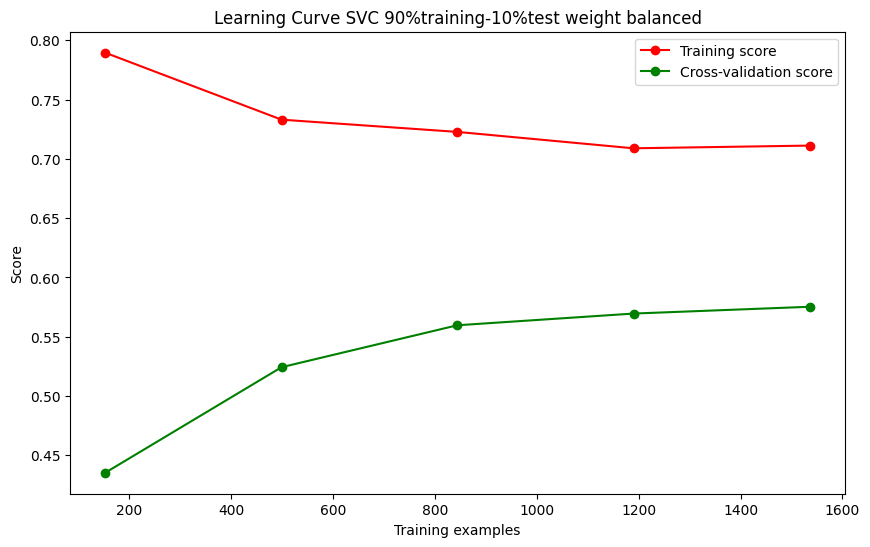

In [ ]:
# Obtener las curvas de aprendizaje
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    classifier, X_train_bow, y_train, cv=5, scoring='accuracy', n_jobs=-1)

# Calcular las medias de las puntuaciones
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Graficar las curvas de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve SVC 90%training-10%test weight balanced")
plt.show()

Tras la segmentación, hemos conseguido una gráfica del aprendizaje más cercana a lo ideal (training y validation tiendan a converger) pero no hemos mejorado el accuracy. Esto puede deberse a varios motivos:

- Aunque se haga una detección, seguimos encontrando keypoints que no pertenecen al mosquito (pueden notarse algunos de estos keypoints en la imagen anterior).
- Robustez de SIFT frente a escalas. Esto puede hacer que, realizar un zoom al mosquito, no se detecten más keypoints de los que ya había antes (aunque si debería ayudar a eliminar keypoints no relacionados)
- A veces la segmentación no se realiza de manera correcta, y obtenemos imagenes como esta:

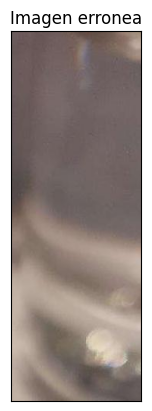

In [ ]:
example_path = '/content/drive/MyDrive/VC_FINAL/Files/Culex_segmentadas_resized/270c3936-95cb-4cfe-87a1-e77b5218d90b.jpg'

img1=readIm(get_image(example_path),1)

displayIm(img1,"Imagen erronea",1)

# Conclusion

Respecto a Bag of Visual Words, encontramos el mejor accuracy como 54.67%. Parece que el modelo BoVW no es el que mejor se ajusta para este dataset, lo cual puede darse por distintos motivos. Las curvas de aprendizaje nos dan a entender que tienden a convergen en algún accuracy entre 70% y 55%, por lo cual quizás con un dataset mayor, se consigan mejores resultados.

También debemos tener en cuenta que las imágenes de mosquitos son tomadas desde perspectivas muy distintas, por lo que los patrones que BoW detecta puede cambiar en función de esta.

Haciendo pruebas del funcionamiento del modelo antes de realizar Data Augmentation, obtuvimos un accuracy muy similar al de después de aplicar Data Augmentation.

¿Por qué no influye data agumentation en el resultado de nuestro problema?
Por la robustez de SIFT.

No importa si aumentamos los datos rotandolos, sift encontrará los mismos keypoints como hemos visto en prácticas anteriores. Por lo tanto, al pasar los descriptores de dichas imágenes a vectores, lo unico que conseguimos es tener datos duplicados, lo cual no aporta ninguna robustez y capacidad de generalización al modelo



La comparación entre esta y modelos de deep learning será discutida en la memoria de la práctica